In [1]:
# make the notebook more readable:
import warnings
warnings.filterwarnings('ignore')
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path:
    sys.path.append(module_path)

# Highly idealised setup

We will test our setup with more idealised boundary conditions. We use the konrad RCE model to generate initial temperature and moisture profiles.

## Create a profile

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

# from typhon import plots
import konrad

def get_konrad_atmosphere(T_s, co2_mult=1.0):
    plev, phlev = konrad.utils.get_pressure_grids(1000e2, 1, 128)
    atmosphere = konrad.atmosphere.Atmosphere(phlev)
    atmosphere['CO2'] = atmosphere['CO2'] * co2_mult
    initial = konrad.atmosphere.Atmosphere(phlev).to_dataset()
    # Initialize the setup for the radiative-convective equilibrium simulation.
    rce = konrad.RCE(
        atmosphere,
        surface=konrad.surface.FixedTemperature(temperature=T_s),  # Run with a fixed surface temperature.
        timestep='12h',  # Set timestep in model time.
        max_duration='100d',  # Set maximum runtime.
    )
    rce.run()
    return atmosphere.to_dataset()

konrad_control = get_konrad_atmosphere(300).isel(time=0)
# konrad_warm = get_konrad_atmosphere(304).isel(time=0)
konrad_control

<xarray.Dataset>
Dimensions:  (plev: 128, phlev: 129)
Coordinates:
    time     int64 0
  * plev     (plev) float64 9.776e+04 9.339e+04 8.916e+04 ... 1.398 1.223 1.07
  * phlev    (phlev) float64 1e+05 9.557e+04 9.127e+04 ... 1.308 1.144 1.0
Data variables: (12/13)
    T        (plev) float64 299.3 297.8 296.3 294.7 ... 189.0 183.1 174.2 159.6
    H2O      (plev) float64 0.02772 0.02657 0.02541 ... 1.832e-05 1.832e-05
    N2O      (plev) float64 3.06e-07 3.06e-07 3.06e-07 ... 3.06e-07 3.06e-07
    O3       (plev) float64 4.452e-41 2.004e-39 ... 9.337e-08 8.351e-08
    O2       (plev) float64 0.2095 0.2095 0.2095 0.2095 ... 0.2095 0.2095 0.2095
    CO2      (plev) float64 0.000348 0.000348 0.000348 ... 0.000348 0.000348
    ...       ...
    CH4      (plev) float64 1.65e-06 1.65e-06 1.65e-06 ... 1.65e-06 1.65e-06
    CFC11    (plev) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    CFC12    (plev) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    CFC22    (plev) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    CCl4     (plev) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    z        (plev) float64 200.8 608.2 1.02e+03 ... 8.088e+04 8.155e+04

In [3]:
konrad_control['H2O'].attrs

{}

Overview over the files we have to manipulate

In [4]:
import os
BASE_PATH = '/work/mh1126/m300872/unchanged/'

grid = dict()
for dom in ['DOM01','DOM02']:
    grid[dom] = xr.open_dataset(BASE_PATH+'grids/'+f'EUREC4A_PR1250m_{dom}.nc')
    print(dom, '  ncell:', grid[dom].cell.shape)
    
init_path = BASE_PATH+'initc/20200109/'+'initc_EUREC4A_PR1250m_DOM01_2020010910.nc'
init = xr.open_dataset(init_path)
print('initcon', 'ncell:', init.ncells.shape)

latbc_path = BASE_PATH+'latbc/lateral_boundary_DOM01.grid.nc'
latbc = xr.open_dataset(latbc_path)
print('latbc  ', 'ncell:', latbc.cell.shape)

DOM01   ncell: (4528560,)
DOM02   ncell: (11792076,)
initcon ncell: (4528560,)
latbc   ncell: (174068,)


Load a random latbc file.

In [5]:
def example_latbcfile():
    latbc_path = '/work/mh1126/m300872/unchanged/latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010801.nc'
    return xr.open_dataset(latbc_path)

latbc = example_latbcfile()

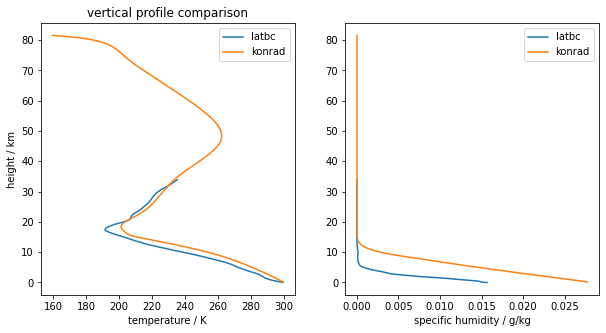

In [6]:
def interpolate_full_level(half_level):
    return np.asarray([(half_level[i]+half_level[i-1])/2 for i in range(1,len(half_level))])

def add_full_level(dataset):
    dataset['z'] = interpolate_full_level(dataset.z_ifc.values)
    return dataset

def fig_vertical_comparison(a,b):
    fig, axs = plt.subplots(1,2, figsize=(10,5))
    ax = axs[0]
    ax.set_title('vertical profile comparison')
    ax.plot(a['temp'].values, a['z'].values/1000, label='latbc')
    ax.plot(b['T'], b['z']/1000, label='konrad')
    ax.set_xlabel('temperature / K')
    ax.set_ylabel('height / km')
    ax.legend()
    ax = axs[1]
    ax.plot(a['qv'].values, a['z'].values/1000, label='latbc')
    ax.plot(b['H2O'], b['z'] /1000, label='konrad')
    ax.set_xlabel('specific humidity / g/kg')
    ax.legend()
    return fig, axs


profile = add_full_level(latbc.mean(dim=['time', 'ncells']))
fig, axs = fig_vertical_comparison(profile, konrad_control)
fig.show()

## Regridding 

The konrad data reaches much higher into the atmosphere. The ICON vertical grid has a tighter spacing in the lower part.

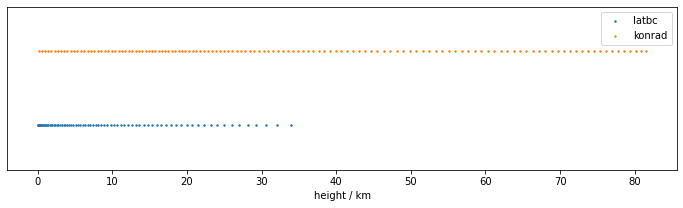

In [7]:
import plot_utils as pu

def fig_vertical_grid_spacing(a, b, xlim=False):
    fig, ax = plt.subplots(figsize=(12,3))
    ax.scatter(a.z.values/1000, np.ones(len(a.z.values)) * 0.5, s=2, label='latbc')
    ax.scatter(b.z.values/1000, np.ones(len(b.z.values)), s=2 , label='konrad')
    ax.set_ylim(0.2,1.3)
    if xlim: ax.set_xlim(*xlim)
    ax.set_xlabel('height / km')
    ax.legend()
    pu.remove_ticks(ax,['left', 'right'])
    return fig, ax

fig, ax = fig_vertical_grid_spacing(profile, konrad_control)
fig.show()

Now we have to find a method of regridding. The easiest solution will be nearest neighbor. A comparison to more accurate approaches like linear interpolation can be tested later. 

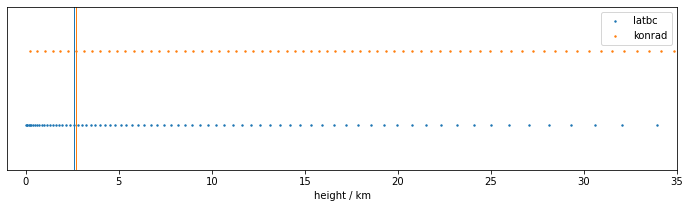

In [8]:
import random 

def find_nearest_index(array, value):
    difference_array = np.absolute(array - value)
    return difference_array.argmin()

def fig_vertical_grid_spacing_marked_line(a, b, xlim=(-1,35)):
    rand_index = random.randint(0, len(a.z.values))
    value = a.z.values[rand_index]
    array = b.z.values
    index = find_nearest_index(array, value)

    fig, ax = fig_vertical_grid_spacing(a, b, xlim=xlim)
    ax.axvline(value/1000, lw=1)
    ax.axvline(array[index]/1000, lw=1, color='tab:orange')
    return fig, ax

fig, ax = fig_vertical_grid_spacing_marked_line(profile, konrad_control)
fig.show()

In [9]:
def regrid_konrad_data(konrad_data, target_height_levels):
    '''
    returns regrided fields for pressure, temperature and specific humidity in form of a dictionary.
    '''
    regridded = dict()
    for key in ['pres', 'temp', 'qv']:
        regridded[key] = list()

    for z in target_height_levels:
        i = find_nearest_index(konrad_data.z.values, z)
        regridded['pres'].append(konrad_data['plev'].values[i])
        regridded['temp'].append(konrad_data['T'   ].values[i])
        regridded['qv'  ].append(konrad_data['H2O' ].values[i])
    return regridded

def zero_fields(dataset, zero_vars = ['w', 'qc', 'qi', 'qr', 'qs', 'u', 'v']):
    '''
    sets variables to zero.
    '''
    return_data = dataset.copy()
    for var in zero_vars:
        return_data[var].values *= 0.0
    return return_data

regridded = regrid_konrad_data(konrad_control, profile.z.values)
for k,v in regridded.items():
    print(k.rjust(4),':',len(v), 'values')

pres : 75 values
temp : 75 values
  qv : 75 values


now we have to apply these regridded values to a dataset

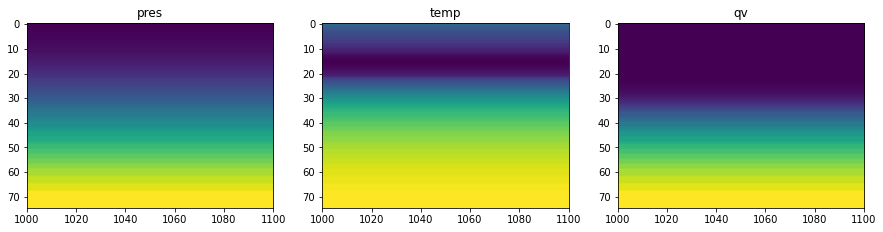

In [10]:
def replace_values_in_dataset(array, replacement):
    array = array.copy()
    for var in replacement.keys():    
        array[var].values *= 0 # delete previous data
        for l in range(len(replacement[var])):
            # replace level by level
            array[var].values[:,l,:] += replacement[var][l]
    return array
        
a = example_latbcfile()
a = replace_values_in_dataset(a, regridded)

def fig_overview_hovmoeller(dataset):
    fig, axs = plt.subplots(1,3, figsize=(15,10))
    for ax, var in zip(axs,['pres','temp','qv']):
        ax.imshow(dataset[var].values[0,:,:])
        ax.set_xlim(1000,1100)
        ax.set_title(var)
    return fig, axs

fig, axs = fig_overview_hovmoeller(a)
fig.show()

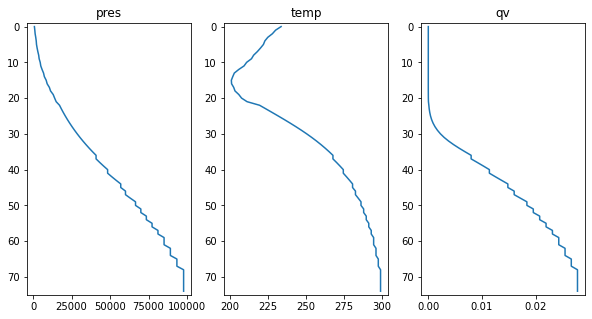

In [11]:
def fig_overview_profiles(dataset):
    fig, axs = plt.subplots(1,3, figsize=(10,5))
    for ax, var in zip(axs,['pres','temp','qv']):
        ax.plot(dataset[var].values[0,:,0], (range(len(dataset[var].values[0,:,0]))))
        ax.set_title(var)
        ax.set_ylim(len(dataset[var].values[0,:,0]), -1)
    return fig, axs

fig, axs = fig_overview_profiles(a)
fig.show()

now this has to be turned into a slurm script, so i can submit it to the queue. I need a function that receives two filenames: input and output. It will write a duplicate of the input file in the location of the output file. This is what I did for the warming. It is less important to read in a file in this idealised setup, but it will allow me to reuse a lot of the old code. 

Running konrad to create the profile takes several seconds, so I don't want to repeat it too often. Having a function that stores the ready to use regridded profile in a global variable might be a solution to that. 

In [12]:
SURFACE_TEMPERATURE = False
KONRAD_REGRID_DATA = False

def set_konrad_data(surface_temperature):
    global SURFACE_TEMPERATURE
    global KONRAD_REGRID_DATA
    profile = add_full_level(example_latbcfile().mean(dim=['time', 'ncells']))
    KONRAD_REGRID_DATA = regrid_konrad_data(get_konrad_atmosphere(surface_temperature).isel(time=0), profile.z.values)
    SURFACE_TEMPERATURE = surface_temperature
    
def get_konrad_data(surface_temperature):
    global SURFACE_TEMPERATURE
    global KONRAD_REGRID_DATA
    if not KONRAD_REGRID_DATA: set_konrad_data(surface_temperature)
    if not SURFACE_TEMPERATURE == surface_temperature: set_konrad_data(surface_temperature)
    return KONRAD_REGRID_DATA

In [13]:
def translate_latbc(ifile, ofile, surface_temperature):
    i = xr.open_dataset(ifile)
    o = replace_values_in_dataset(i, get_konrad_data(surface_temperature))
    o.to_netcdf(ofile)

# get_konrad_atmosphere(304)
source = '/work/mh1126/m300872/unchanged/'
target = '/work/mh1126/m300872/cold_konrad/'
relpath = 'latbc/20200111'

# path_pair = os.path.join(source, relpath, os.listdir(source+'latbc/20200111')[0]), os.path.join(target, relpath, os.listdir(source+'latbc/20200111')[0])
for p in os.listdir(source+'latbc/20200111'):
    translate_latbc(os.path.join(source, relpath, p), os.path.join(target, relpath, p), 300)

# surface_temperature = 300
# # surface_temperature = 302
# # set_konrad_data(surface_temperature)
# get_konrad_data(surface_temperature)


In [14]:
print(len(os.listdir(os.path.join(source, relpath))), ' files')
for p in os.listdir(os.path.join(source, relpath)):
    print(p, os.path.exists(os.path.join(target, relpath, p)))

24  files
latbc_EUREC4A_PR1250m_DOM01_2020011106.nc True
latbc_EUREC4A_PR1250m_DOM01_2020011101.nc True
latbc_EUREC4A_PR1250m_DOM01_2020011103.nc True
latbc_EUREC4A_PR1250m_DOM01_2020011123.nc True
latbc_EUREC4A_PR1250m_DOM01_2020011114.nc True
latbc_EUREC4A_PR1250m_DOM01_2020011107.nc True
latbc_EUREC4A_PR1250m_DOM01_2020011115.nc True
latbc_EUREC4A_PR1250m_DOM01_2020011121.nc True
latbc_EUREC4A_PR1250m_DOM01_2020011100.nc True
latbc_EUREC4A_PR1250m_DOM01_2020011110.nc True
latbc_EUREC4A_PR1250m_DOM01_2020011118.nc True
latbc_EUREC4A_PR1250m_DOM01_2020011112.nc True
latbc_EUREC4A_PR1250m_DOM01_2020011120.nc True
latbc_EUREC4A_PR1250m_DOM01_2020011109.nc True
latbc_EUREC4A_PR1250m_DOM01_2020011108.nc True
latbc_EUREC4A_PR1250m_DOM01_2020011104.nc True
latbc_EUREC4A_PR1250m_DOM01_2020011122.nc True
latbc_EUREC4A_PR1250m_DOM01_2020011113.nc True
latbc_EUREC4A_PR1250m_DOM01_2020011111.nc True
latbc_EUREC4A_PR1250m_DOM01_2020011117.nc True
latbc_EUREC4A_PR1250m_DOM01_2020011105.nc True
lat

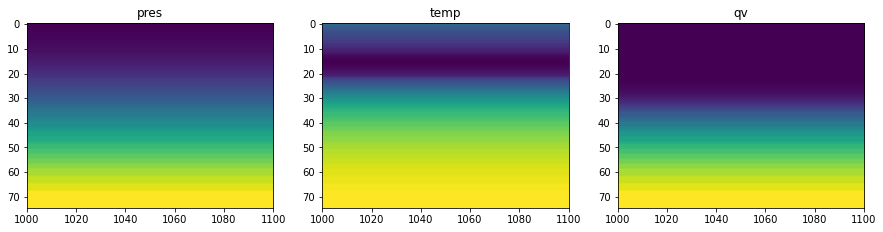

In [15]:
path_pair = os.path.join(source, relpath, os.listdir(source+'latbc/20200111')[0]), os.path.join(target, relpath, os.listdir(source+'latbc/20200111')[0])
o = xr.open_dataset(path_pair[0]) 
k = xr.open_dataset(path_pair[1])

fig, axs = fig_overview_hovmoeller(k); fig.show()

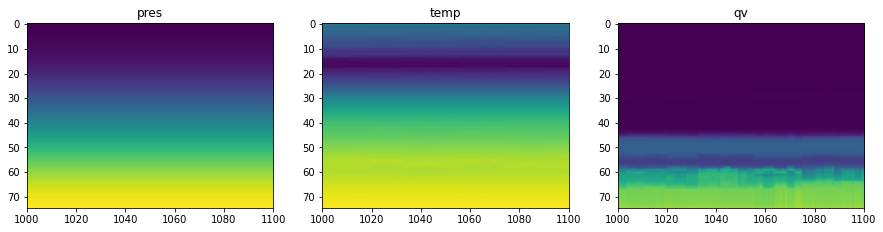

In [16]:
fig, axs = fig_overview_hovmoeller(o); fig.show()

In [17]:
def fig_compare_profiles(datasets):
    fig, axs = plt.subplots(1,3, figsize=(10,5))
    for ax, var in zip(axs,['pres','temp','qv']):
        for d in datasets:
            ax.plot(d[var].values[0,:,0], (range(len(d[var].values[0,:,0]))))
        ax.set_title(var)
        ax.set_ylim(len(datasets[0][var].values[0,:,0]), -1)
    return fig, axs

fig, axs = fig_compare_profiles([k,o]); fig.show()

this seems to work. The specific humidity is quite high and the temperature profile is not a perfect fit either. But we can refine that later. Paul suggested to set a different `q0` (surface specific humidity can be set [in this function](https://konrad.readthedocs.io/_autosummary/konrad.utils.humidity_profile_rcemip.html?highlight=humidity_profile_rcemip)) or to [activate entrainment](https://konrad.readthedocs.io/konrad.entrainment.html) to get a more realistic temperature profile.

## Parallelisation via slurm scripts

First we set up the empty directory structure

In [18]:
import file_handling as fh

def duplicate_directory_structure(target, source='/work/mh1126/m300872/unchanged/'):
    latbc_files = fh.get_filelist(source, 'latbc/')[1::]
    initc_files = fh.get_filelist(source, 'initc')
    sstsi_files = [f for f in fh.get_filelist(source, 'sst_sic') if 'DOM01' in f or 'DOM02' in f]
    file_list = latbc_files + initc_files + sstsi_files
    
    for f in file_list:
        dirpath = os.path.join(target,fh.dirname(f))
        os.makedirs(dirpath, exist_ok=True)
        
duplicate_directory_structure('/work/mh1126/m300872/cold_konrad/')

In [46]:
import pandas as pd
import subprocess as sub
import os

def seconds2clockstring(s):
    hours, remainder = divmod(s, 3600)
    minutes, seconds = divmod(remainder, 60)
    return '{:02}:{:02}:{:02}'.format(int(hours), int(minutes), int(seconds))

def minutes2clockstring(m):
    s = pd.Timedelta(m, 'm').total_seconds()
    return seconds2clockstring(s)
    
def slurm_header(minutes, account='mh1126'):
    return f'''#!/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/bin/python
#SBATCH --partition=compute
#SBATCH --account={account}
#SBATCH --nodes=1
#SBATCH --time={minutes2clockstring(minutes)}
#SBATCH --mail-type=fail
#SBATCH --mail-user=hernan.campos@mpimet.mpg.de
#SBATCH --output=%j_%x.log
'''

def functions_static():
    return '''
import os
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path:
    sys.path.append(module_path)

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import file_handling as fh
import konrad

def example_latbcfile():
    latbc_path = '/work/mh1126/m300872/unchanged/latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010801.nc'
    return xr.open_dataset(latbc_path)

def get_konrad_atmosphere(T_s, co2_mult=1.0):
    plev, phlev = konrad.utils.get_pressure_grids(1000e2, 1, 128)
    atmosphere = konrad.atmosphere.Atmosphere(phlev)
    atmosphere['CO2'] = atmosphere['CO2'] * co2_mult
    initial = konrad.atmosphere.Atmosphere(phlev).to_dataset()
    # Initialize the setup for the radiative-convective equilibrium simulation.
    rce = konrad.RCE(
        atmosphere,
        surface=konrad.surface.FixedTemperature(temperature=T_s),  # Run with a fixed surface temperature.
        timestep='12h',  # Set timestep in model time.
        max_duration='100d',  # Set maximum runtime.
    )
    rce.run()
    return atmosphere.to_dataset()

def interpolate_full_level(half_level):
    return np.asarray([(half_level[i]+half_level[i-1])/2 for i in range(1,len(half_level))])

def add_full_level(dataset):
    dataset['z'] = interpolate_full_level(dataset.z_ifc.values)
    return dataset

def find_nearest_index(array, value):
    difference_array = np.absolute(array - value)
    return difference_array.argmin()

def regrid_konrad_data(konrad_data, target_height_levels):
    # returns regrided fields for pressure, temperature and specific humidity in form of a dictionary.
    regridded = dict()
    for key in ['pres', 'temp', 'qv']:
        regridded[key] = list()

    for z in target_height_levels:
        i = find_nearest_index(konrad_data.z.values, z)
        regridded['pres'].append(konrad_data['plev'].values[i])
        regridded['temp'].append(konrad_data['T'   ].values[i])
        regridded['qv'  ].append(konrad_data['H2O' ].values[i])
    return regridded

def zero_fields(dataset, zero_vars = ['w', 'qc', 'qi', 'qr', 'qs', 'u', 'v']):
    # sets variables to zero.
    return_data = dataset.copy()
    for var in zero_vars:
        return_data[var].values *= 0.0
    return return_data

def replace_values_in_dataset(array, replacement):
    array = zero_fields(array.copy())
    for var in replacement.keys():    
        array[var].values *= 0 # delete previous data
        for l in range(len(replacement[var])):
            # replace level by level
            array[var].values[:,l,:] += replacement[var][l]
    return array

SURFACE_TEMPERATURE = False
KONRAD_REGRID_DATA = False

def set_konrad_data(surface_temperature):
    global SURFACE_TEMPERATURE
    global KONRAD_REGRID_DATA
    profile = add_full_level(example_latbcfile().mean(dim=['time', 'ncells']))
    KONRAD_REGRID_DATA = regrid_konrad_data(get_konrad_atmosphere(surface_temperature).isel(time=0), profile.z.values)
    SURFACE_TEMPERATURE = surface_temperature
    
def get_konrad_data(surface_temperature):
    global SURFACE_TEMPERATURE
    global KONRAD_REGRID_DATA
    if not KONRAD_REGRID_DATA: set_konrad_data(surface_temperature)
    if not SURFACE_TEMPERATURE == surface_temperature: set_konrad_data(surface_temperature)
    return KONRAD_REGRID_DATA

def translate_latbc(ifile, ofile, surface_temperature):
    i = xr.open_dataset(ifile)
    o = replace_values_in_dataset(i, get_konrad_data(surface_temperature))
    o.to_netcdf(ofile)
'''
    
def latbc_script_body(division=False, 
                      in_directory='/work/mh1126/m300872/unchanged/',
                      out_directory='/work/mh1126/m300872/cold_konrad/',
                      surface_temperature=300):
    return f'''
IN_DIRECTORY  = '{in_directory}'
OUT_DIRECTORY = '{out_directory}'
division = {division}
latbc_files = [f for f in fh.get_filelist(IN_DIRECTORY, 'latbc/') if not 'grid' in f]

if division: latbc_files = fh.sublist(latbc_files, division[0], division[1])

args_list = list()
for f in latbc_files:
    ifile = os.path.join(IN_DIRECTORY,f)
    ofile = os.path.join(OUT_DIRECTORY,f)
    args_list.append((ifile,ofile,{surface_temperature}))

for args in args_list:
    print(*args)
    translate_latbc(*args)
'''

nscripts = 2
for i in range(nscripts):
# for i in [1]:
    # division = fh.sublist(range(nscripts,i)
    filename = f'sbatch_konradlatbc-{i+1}_of_{nscripts}.py'
    script  = slurm_header(30) + functions_static()
    script += latbc_script_body(division=(nscripts, i), surface_temperature=300, out_directory='/work/mh1126/m300872/cold_konrad/')
    with open(filename, "w") as text_file: 
        text_file.write(script)

    print(['sbatch ', filename])
    sub.run(["sbatch", filename])

['sbatch ', 'sbatch_konradlatbc-1_of_2.py']
Submitted batch job 4991399
['sbatch ', 'sbatch_konradlatbc-2_of_2.py']
Submitted batch job 4991400


In [41]:
import postprocessing as pp 
x = list(range(100))
nlists = 7
for i in range(nlists):
    print(fh.sublist(x,nlists,i))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
[15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]
[44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57]
[58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71]
[72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85]
[86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


In [20]:
log = 4685317
log = str(log)+'_test.py.log'
print(log)
# log = '4665263_test.py.log'

with open(log, "r") as text_file: 
    loglines = text_file.readlines()

print()
print(len(loglines), ' lines')
for l in loglines:
    print(l)

4685317_test.py.log

0  lines


In [21]:
import numpy as np
nums = np.linspace(0,400,20)
nums

array([  0.        ,  21.05263158,  42.10526316,  63.15789474,
        84.21052632, 105.26315789, 126.31578947, 147.36842105,
       168.42105263, 189.47368421, 210.52631579, 231.57894737,
       252.63157895, 273.68421053, 294.73684211, 315.78947368,
       336.84210526, 357.89473684, 378.94736842, 400.        ])

In [22]:
sub.call(['squeue', '-u', 'm300872'])

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           4991102   compute sbatch_k  m300872 PD       0:00      1 (None)
           4991012 interacti spawner-  m300872  R       9:11      1 l40055


0

## Create `initcon`

the creation of the `initcon` is a little bit more complicated, because we have to write into a single file that is too big to hold in memory with a notebook or a single node slurm job.

In [23]:
IN_DIRECTORY  = '/work/mh1126/m300872/unchanged/'
OUT_DIRECTORY = '/work/mh1126/m300872/cold_konrad/'
latbc_files = [f for f in fh.get_filelist(IN_DIRECTORY, 'latbc/') if not 'grid' in f]

division = (400,1)

if division: latbc_files = fh.sublist(latbc_files, division[0], division[1])

args_list = list()
for f in latbc_files:
    ifile = os.path.join(IN_DIRECTORY,f)
    ofile = os.path.join(OUT_DIRECTORY,f)
    args_list.append((ifile,ofile,300))

for arg in args_list:
    print(*arg)

/work/mh1126/m300872/unchanged/latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010804.nc /work/mh1126/m300872/cold_konrad/latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010804.nc 300
/work/mh1126/m300872/unchanged/latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010805.nc /work/mh1126/m300872/cold_konrad/latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010805.nc 300
/work/mh1126/m300872/unchanged/latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010806.nc /work/mh1126/m300872/cold_konrad/latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010806.nc 300


In [24]:
showstopper()

NameError: name 'showstopper' is not defined

In [ ]:

def latbc_script_body(division=False, 
                      in_directory='/work/mh1126/m300872/unchanged/',
                      out_directory='/work/mh1126/m300872/moist_adiabatic/',
                      temperatures=(304,300)):
    return f'''
IN_DIRECTORY  = '{in_directory}'
OUT_DIRECTORY = '{out_directory}'
division = {division}
latbc_files = [f for f in get_filelist(IN_DIRECTORY, 'latbc/') if not 'grid' in f]
create_directory_structure(latbc_files, OUT_DIRECTORY)
if division: latbc_files = sublist(latbc_files, division[0], division[1])

warming_profile = delta_adiabatic_profile({temperatures[0]}, {temperatures[1]}, IN_DIRECTORY+'latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010801.nc')
                                           
args_list = list()
for f in latbc_files:
    ifile = os.path.join(IN_DIRECTORY,f)
    ofile = os.path.join(OUT_DIRECTORY,f)
    args_list.append((ifile,ofile,warming_profile))

for args in args_list:
    warm_atmospheric_profile(*args)
'''

def initc_script_body(in_directory='/work/mh1126/m300872/unchanged/',
                      out_directory='/work/mh1126/m300872/moist_adiabatic/',
                      temperatures=(304,300)):
    return f'''
IN_DIRECTORY  = '{in_directory}'
OUT_DIRECTORY = '{out_directory}'
initc_files = get_filelist(IN_DIRECTORY, 'initc')
create_directory_structure(initc_files, OUT_DIRECTORY)
print(initc_files)

warming_profile = delta_adiabatic_profile({temperatures[0]}, {temperatures[1]}, IN_DIRECTORY+'latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010801.nc')

ifile = os.path.join(IN_DIRECTORY,initc_files[0])
ofile = os.path.join(OUT_DIRECTORY,initc_files[0])
varnames = dict()
varnames['pressure']    = 'p'
varnames['temperature'] = 't'
print(varnames)
d = xr.open_dataset(ifile)
d = add_relative_humidity(d, varnames=varnames)
d = add_to_temperature(d, warming_profile, varnames=varnames)
d = restore_specific_humidity(d, drop_RH=True, varnames=varnames)
d = add_prognostic_variables(d, varnames=varnames)
d.to_netcdf(ofile)
'''

def sstsic_script_body(division=False, 
                      in_directory='/work/mh1126/m300872/unchanged/',
                      out_directory='/work/mh1126/m300872/moist_adiabatic/',
                      temperatures=(304,300)):
    return f'''
import netCDF4 as nc
import xarray as xr
import subprocess as sup
# from functions_boundaries import *

IN_DIRECTORY  = '{in_directory}'
OUT_DIRECTORY = '{out_directory}'
division = {division}
temperatures = {temperatures}

print(division)
sstsic_files = [f for f in get_filelist(IN_DIRECTORY, 'sst_sic') if 'DOM01' in f or 'DOM02' in f or 'DOM03' in f]
if division: sstsic_files = sublist(sstsic_files, division[0], division[1])
create_directory_structure(sstsic_files, OUT_DIRECTORY)
    
# pack arguments
delta = temperatures[1] - temperatures[0]
args_list = list()
for f in sstsic_files:
    ifile = os.path.join(IN_DIRECTORY,f)
    ofile = os.path.join(OUT_DIRECTORY,f)
    args_list.append((ifile,ofile,delta))

for args in args_list:
    # copy original file, then overwrite SST timestepwise (file to big to write at once)
    (ifile, ofile, delta) = args
    sup.call(['cp', ifile, ofile])
    time_shape = xr.open_dataset(ifile).time.values.shape
    with nc.Dataset(args[1], mode='a') as fp:
        for i in range(time_shape[0]):
            chunk = xr.open_dataset(ifile)['SST'].isel(time=i).values + delta
            fp['SST'][i] = chunk
'''

def try_remove(path):
    try:os.remove(path)
    except: pass

def launch_script(body, name='/scratch/m/m300872/generated_script.py'):
    try_remove(name)
    with open(name, 'w') as file:
        file.write(body)
    sup.call(['sbatch', name])
    try_remove(name)
    
def launch_latbc_scripts(n_scripts=100):
    for script_id in range(n_scripts):
        script = slurm_header(5) + functions + latbc_script_body(division=(n_scripts, script_id))
        launch_script(script)

def launch_initc_script():
    script = slurm_header(10) + functions + initc_script_body()
    launch_script(script)

def launch_sstsic_script(n_scripts=3):
    for script_id in range(n_scripts):
        script = slurm_header(15) + functions + sstsic_script_body(division=(n_scripts, script_id))
        launch_script(script)

In [ ]:

args_list = list()
for f in latbc_files[0:3]:
    ifile = os.path.join(IN_DIRECTORY,f)
    ofile = os.path.join(OUT_DIRECTORY,f)
    args_list.append({'ifile':ifile, 'ofile':ofile, 'profile':delta})

for args in args_list:
    warm_atmospheric_profile(args)
    
    
    

In [ ]:
showstopper()

In [ ]:
import metpy.calc as mpcalc
from metpy.units import units

def add_prognostic_variables(dataset, varnames=None):
    varnames = add_varnames_to_default(varnames)
    p  = dataset[varnames['pressure']].values    * units('pascal')
    t  = dataset[varnames['temperature']].values * units('kelvin')
    qv = dataset[varnames['specific humidity']].values   # ratio of water vapor mass to total moist air parcel mass
    
    eps   = mpcalc.mixing_ratio_from_specific_humidity(qv)
    theta = mpcalc.virtual_potential_temperature(p,t,eps)
    rho   = mpcalc.density(p, t, eps)
    
    dimnames = dataset[varnames['temperature']].dims
    dataset[varnames['virtual potential temperature']] = (dimnames, theta.magnitude)
    dataset[varnames['density']] = (dimnames, rho.magnitude)
    return dataset


In [ ]:
T_s = 300; co2_mult = 1.0

plev, phlev = konrad.utils.get_pressure_grids(1000e2, 1, 128)
atmosphere = konrad.atmosphere.Atmosphere(phlev)
atmosphere['CO2'] = atmosphere['CO2'] * co2_mult
initial = konrad.atmosphere.Atmosphere(phlev).to_dataset()
# Initialize the setup for the radiative-convective equilibrium simulation.
rce = konrad.RCE(
    atmosphere,
    surface=konrad.surface.FixedTemperature(temperature=T_s),  # Run with a fixed surface temperature.
    timestep='12h',  # Set timestep in model time.
    max_duration='100d',  # Set maximum runtime.
)
rce.run()
atmosphere.calculate_height()

In [ ]:
fig, ax = plt.subplots()
ax.plot(konrad_control.T, konrad_control.z, color='r')
# ax.plot(konrad_warm.T, konrad_warm.z, color='r', ls=':')
ax = ax.twiny()
ax.plot(konrad_control.H2O, konrad_control.z, color='tab:blue')
# ax.plot(konrad_warm.H2O, konrad_warm.z, ls=':', color='tab:blue')
plt.show()

In [ ]:
# https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.add_pressure_to_height.html
# Calculate the height at a certain pressure above another height.
# This assumes a standard atmosphere [NOAA1976].
# height (pint.Quantity) – Height level
# pressure (pint.Quantity) – Pressure above height level

from metpy.calc import add_pressure_to_height
from metpy.units import units

p = np.flip(konrad_control['z'].values)
z = [0  * units.meters ]
for i in range(len(p)-1):
    dp = p[i] - p[i+1]
    dz = add_pressure_to_height(z[i], dp * units.Pa).to(units.meter)
    z.append(z[i] + dz)
    print(z[i], dp, dz)

In [ ]:
import os
import xarray as xr
BASE_PATH = '/work/mh1126/m300872/unchanged/'
latbc = xr.open_dataset(BASE_PATH+'latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010801.nc').mean(dim='time')
latbc_copy = latbc.copy() # for later reference
latbc

In [ ]:
manipulate_values = ['qv', 'temp', 'pres']
set_zeros = ['qc', 'qi', 'qr', 'qs', 'u', 'v', 'w']
for var in set_zeros: latbc[var].values *= 0.0
latbc.z_ifc.values, len(latbc.z_ifc.values)

In [ ]:
latbc.z_ifc.median(dim='ncells').shape, latbc.z_ifc.median(dim='ncells').values

In [ ]:
konrad_control.z.values, len(konrad_control.z.values)